In [1]:
from cocpit.plotting_scripts import roc
import cocpit
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from cocpit import config as config
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc as plot_roc
from cocpit import roc_utils as roc_utils
%load_ext autoreload
%autoreload 2

In [2]:
plt_params = {
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "legend.title_fontsize": 14,
    "legend.fontsize": 12,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

In [3]:
#  make predictions on each batch of images,
#  and concatenate the precitions across batches

fold_max_preds = []
fold_topk_classes = []
fold_topk_probs = []
fold_labels = []

with torch.no_grad():
    for fold in range(config.KFOLD+1):
        print(fold)
        p = cocpit.predictions.LoaderPredictions()
        model = p.load_model(fold)
        val_loader = p.load_val_loader(fold)
        for ((imgs, labels, paths), batch) in val_loader:
            b = cocpit.predictions.BatchPredictions(imgs, model)
            b.find_max_preds()
            b.top_k_preds(len(config.CLASS_NAMES))
            p.append_batch(b, paths, labels)
        p.concatenate_loader_vars()
        fold_max_preds.append(p.max_preds)
        fold_topk_classes.append(p.topk_classes)
        fold_topk_probs.append(p.topk_probs)
        fold_labels.append([i.item() for i in p.labels])



0
1
2
3
4
5


In [4]:
# 1st and 5th fold have one more image
# truncate all vars to same length so we can reshape
# and add fold dimension
len_preds = [len(i) for i in fold_max_preds]
min_len = min(len_preds)

fold_max_preds = [i[:min_len] for i in fold_max_preds]
fold_topk_classes = [i[:min_len] for i in fold_topk_classes]
fold_topk_probs = [i[:min_len] for i in fold_topk_probs]
fold_labels = [i[:min_len] for i in fold_labels]

max_preds_rs = np.reshape(np.concatenate(fold_max_preds), (config.KFOLD+1, len(fold_max_preds[0])))
topk_classes_rs = np.reshape(np.concatenate(fold_topk_classes), (config.KFOLD+1, len(fold_max_preds[0]), len(config.CLASS_NAMES)))
topk_probs_rs = np.reshape(np.concatenate(fold_topk_probs), (config.KFOLD+1, len(fold_max_preds[0]), len(config.CLASS_NAMES)))
fold_labels_rs = np.reshape(np.concatenate(fold_labels), (config.KFOLD+1, len(fold_max_preds[0])))

In [5]:
# convert predictions into shape [fold, n_samples, n_classes]
# where predictions are in order of class number (0,1,2)
# not highest to lowest probability
yhat_proba = np.zeros((config.KFOLD+1, len(fold_max_preds[0]), len(config.CLASS_NAMES)))
for f in range(config.KFOLD+1):
    for i in range(len(fold_max_preds[0])):
        for c in range(len(config.CLASS_NAMES)):
            yhat_proba[f, i, c] = topk_probs_rs[f,i][np.where(topk_classes_rs[f,i] == c)[0][0]]


AUC: 0.99
AUC: 0.98
AUC: 0.99


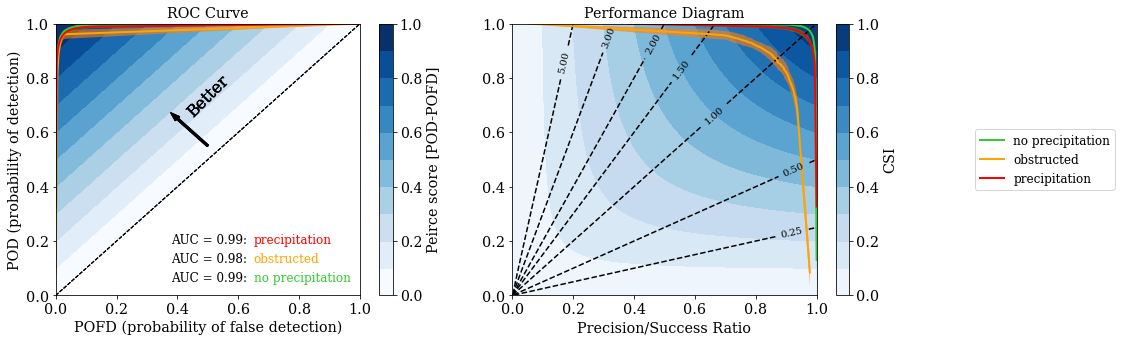

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
roc.peirce_contour(ax1)
roc.csi_contour(ax2)
roc.plot_frequency_bias(ax2)
roc.performance_diagram(ax1, ax2, fold_labels_rs, yhat_proba)
plt.savefig('/ai2es/plots/roc_performance.png', bbox_inches='tight', dpi=300)